In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

%store -r all_tweets
#nltk.download('punkt')
#nltk.download('stopwords')

In [526]:
# LSA analysis
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def clean_tweet(tweet):
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet_tokens = [word for word in tweet_tokens if not word in stop_words and word != 'RT']
    return(tweet_tokens)

# Filter out retweets and non english tweets
# 

#non_rt_tweets = all_tweets[(all_tweets['tweet_text'].str.count("^RT @") == 0)]
#print(non_rt_tweets.shape)
#non_rt_tweets = non_rt_tweets[(non_rt_tweets['language'].str.count("en") == 1)]
#print(non_rt_tweets.shape)
#non_rt_tweets['tokenized_tweet'] = non_rt_tweets['tweet_text'].apply(lambda x: clean_tweet(x))


In [527]:
from sklearn.feature_extraction.text import TfidfVectorizer

#non_rt_tweets['cleaned_tweets'] = non_rt_tweets['tokenized_tweet'].apply(lambda x: ' '.join(x))
#non_rt_tweets.head()
all_tweets['tokenized_tweet'] = all_tweets['tweet_text'].apply(lambda x: clean_tweet(x))
all_tweets['cleaned_tweets'] = all_tweets['tokenized_tweet'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(stop_words='english', max_features = 2000, max_df = 0.5, ngram_range = (1,3))
X = vectorizer.fit_transform(all_tweets['cleaned_tweets'])
X.shape

(447962, 2000)

In [528]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=1)
svd_model.fit(X)
terms = vectorizer.get_feature_names()

topic_dict = {}
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    print(sorted_terms)
    topic_terms = []
    for k in sorted_terms:
        topic_terms.append(k[0])
    topic_dict[i] = topic_terms
    
X_topics = svd_model.fit_transform(X)


Topic 0: 
[('saveourchildren', 0.9224035961633942), ('wwg1wga', 0.34808393181442354), ('qanon', 0.07662869793663274), ('trump2020', 0.04511971965317054), ('realdonaldtrump', 0.045024066339829465), ('savethechildren', 0.04448827109682497), ('hsretoucher', 0.03280921515812711), ('okabaeri9111', 0.025909073765609837), ('qarmyjapanflynn', 0.02587655871101673), ('maga', 0.025863219484585174)]
Topic 1: 
[('wwg1wga', 0.8901308139460998), ('qanon', 0.17346604109286679), ('okabaeri9111', 0.06432409897217135), ('qarmyjapanflynn', 0.06330177097712981), ('realdonaldtrump', 0.04851317764820047), ('trump2020', 0.04551656228630503), ('maga', 0.04538747648641021), ('qanon wwg1wga', 0.03775626238638362), ('wwg1wga qarmyjapanflynn', 0.034490975043178544), ('genflynn', 0.03215787388018282)]
Topic 2: 
[('qanon', 0.9591932843101307), ('trump', 0.05456049014615069), ('qanon wwg1wga', 0.04357029702145223), ('okabaeri9111', 0.03873813593471271), ('realdonaldtrump', 0.0359094454022578), ('maga', 0.033646263237

In [529]:
def set_top_topic(x):
    if(len(np.where(X_topics[x] == max(X_topics[x]))[0])):
        return(np.where(X_topics[x] == max(X_topics[x]))[0][0])
    else:
        return(np.where(X_topics[x] == max(X_topics[x]))[0])
    
def set_top_topic_score(x):
    if(len(np.where(X_topics[x] == max(X_topics[x]))[0])):
        return(round(max(X_topics[x]),4))
    else:
        return(round(max(X_topics[x]),4))

all_tweets['tokenized_tweet'] = all_tweets['tweet_text'].apply(lambda x: clean_tweet(x))
all_tweets['cleaned_tweets'] = all_tweets['tokenized_tweet'].apply(lambda x: ' '.join(x))
X = vectorizer.fit_transform(all_tweets['cleaned_tweets'])
X_topics = svd_model.transform(X)


In [530]:
all_tweets['top_topic'] = [set_top_topic(i) for i in range(0,len(X_topics))]
all_tweets['top_topic_score'] = [set_top_topic_score(i) for i in range(0,len(X_topics))]
all_tweets['topic_desc'] = all_tweets['top_topic'].apply(lambda x: topic_dict[x])

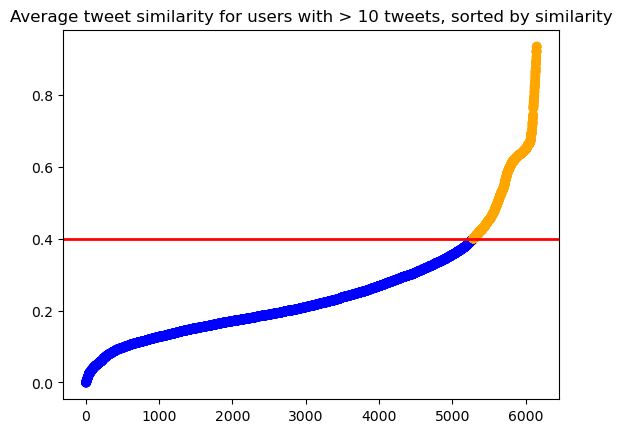

(6151, 8)


,user_id,avg_num_mentions,avg_num_links,follower_ratio,avg_num_hashtags,retweet_unique_proportion,avg_similarity,similarity_label
0,755359,0.643,0.643,0.684,3.714,0.286,0.385,Low similarity
1,872841,0.312,0.875,0.198,1.812,0.000,0.588,High similarity
2,1457101,0.091,1.000,0.529,0.939,0.030,0.096,Low similarity
3,5392032,1.417,0.417,1.268,1.167,1.000,0.210,Low similarity
4,6589322,1.294,0.471,0.622,2.059,0.765,0.155,Low similarity


In [531]:
all_tweets['num_mentions'] = all_tweets['tweet_text'].str.count("@")
all_tweets['num_links'] = all_tweets['tweet_text'].str.count('http')
all_tweets['follower_ratio'] = all_tweets['num_followers'] / (all_tweets['num_following']+1)
all_tweets['num_hashtags'] = all_tweets['tweet_text'].str.count('#')

grouped_users = all_tweets.groupby('user_id')
grouped_users_counts = grouped_users.size().sort_values()

frequent_users = list(grouped_users.size().sort_values().where(grouped_users_counts >= 10 ).dropna().index)
frequent_users_grouped = all_tweets[(all_tweets['user_id'].isin(frequent_users))].groupby('user_id')

non_rt_tweets.head()

unique_users = list(frequent_users_grouped.user_id.unique())
user_df = pd.DataFrame(unique_users, columns = ['user_id'])

user_df['avg_num_mentions'] = [round(frequent_users_grouped.get_group(i)["num_mentions"].mean(),3) for i in user_df['user_id']]
user_df['avg_num_links'] = [round(frequent_users_grouped.get_group(i)["num_links"].mean(),3) for i in user_df['user_id']]
user_df['follower_ratio'] = [round(frequent_users_grouped.get_group(i)["follower_ratio"].mean(),3) for i in user_df['user_id']]
user_df['avg_num_hashtags'] = [round(frequent_users_grouped.get_group(i)["num_hashtags"].mean(),3) for i in user_df['user_id']]
all_frequent_user_tweets = all_tweets[(all_tweets['user_id'].isin(frequent_users))].groupby('user_id')
user_df['retweet_unique_proportion'] = [round(all_frequent_user_tweets.get_group(i)['tweet_text'].str.count("^RT @").sum() / all_frequent_user_tweets.get_group(i).shape[0],3) for i in user_df['user_id']]
user_df['avg_similarity'] = [round(frequent_users_grouped.get_group(i)["top_topic_score"].mean(),3) for i in user_df['user_id']]

def set_quartile(x):
    if x >= 0.4:
        return "High similarity"
    else:
        return "Low similarity"

user_df['similarity_label'] = user_df['avg_similarity'].apply(lambda x: set_quartile(x))

plt.title("Average tweet similarity for users with > 10 tweets, sorted by similarity")
plt.scatter(np.arange(0,len(user_df['avg_similarity'])),np.sort(user_df['avg_similarity']), 
            color = [('orange' if x > 0.4 else 'blue') for x in np.sort(user_df['avg_similarity'])])
plt.axhline(linewidth=2, color='r', y=0.4)
plt.show()

print(user_df.shape)
user_df.head()


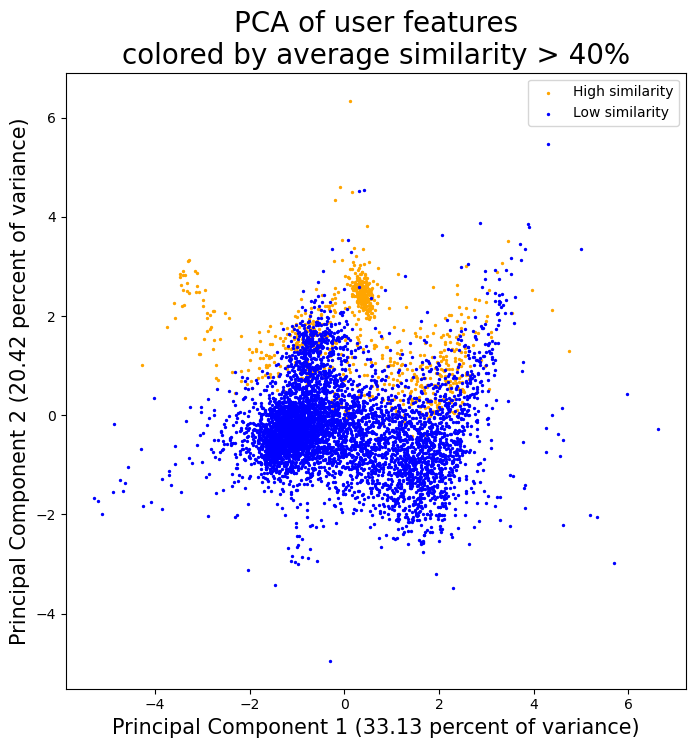

In [532]:

from sklearn.decomposition import PCA

user_colnames = user_df.columns[1:-1]
pca_values = user_df.loc[:,user_colnames]
pca_target = user_df.loc[:,['similarity_label']]

pca_values = StandardScaler().fit_transform(pca_values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_values)
pca_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca_df.index = pca_target.index
pca_df = pd.concat([pca_df,pca_target[['similarity_label']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (%s percent of variance)'%(round(pca.explained_variance_ratio_[0]*100,2)), fontsize = 15)
ax.set_ylabel('Principal Component 2 (%s percent of variance)'%(round(pca.explained_variance_ratio_[1]*100,2)), fontsize = 15)
ax.set_title('PCA of user features\ncolored by average similarity > 40%', fontsize = 20)
targets = ['High similarity','Low similarity']
colors = ['orange','blue']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['similarity_label'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 2)
ax.legend(targets)


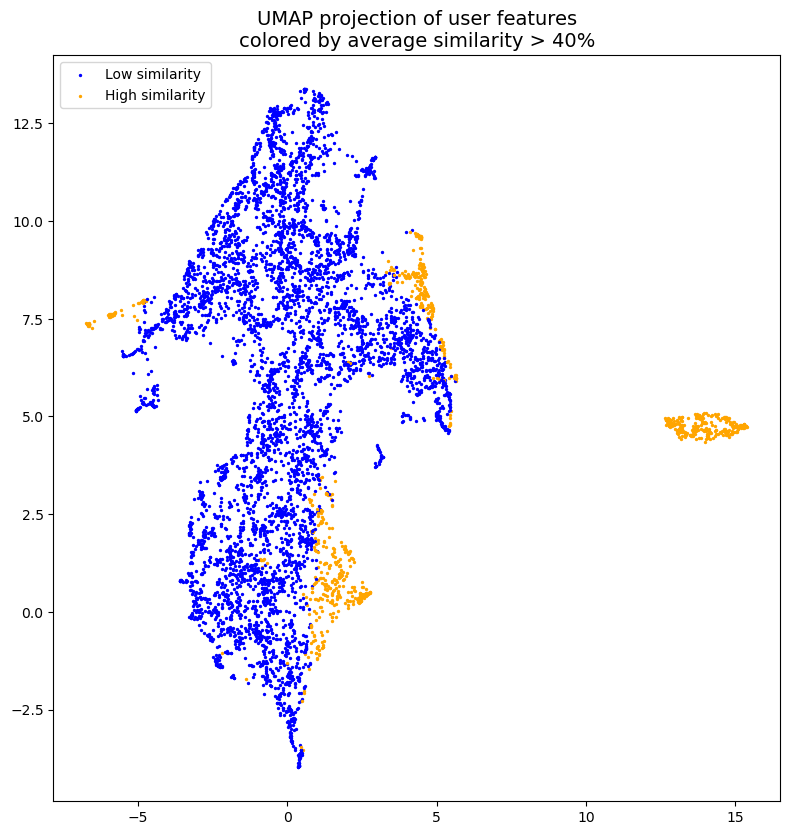

In [544]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(random_state=42)

user_data = user_df.loc[:, user_df.columns != 'similarity_label' ]
user_data = user_data.loc[:, user_data.columns != 'user_id' ].values
user_data = StandardScaler().fit_transform(user_data)
embedding = reducer.fit_transform(user_data)

color_map = {"High similarity":'orange', "Low similarity":'blue'}
labelled = {"High similarity":0, "Low similarity":0}


fig = plt.figure(figsize = (8,8))
for i in range(0,len(embedding)):
    if not labelled[user_df.at[user_df.index[i],"similarity_label"]]:
        labelled[user_df.at[user_df.index[i],"similarity_label"]] = 1
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[user_df.at[user_df.index[i],"similarity_label"]], 
                label = user_df.at[user_df.index[i],"similarity_label"], s=2)
    else:
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[user_df.at[user_df.index[i],"similarity_label"]], s=2)

plt.legend(loc='upper left')
plt.tight_layout()
plt.title('UMAP projection of user features\ncolored by average similarity > 40%', fontsize=14)
plt.rcParams.update(plt.rcParamsDefault)


Index(['avg_num_mentions', 'avg_num_links', 'follower_ratio',
       'avg_num_hashtags', 'retweet_unique_proportion'],
      dtype='object')
0.8545306785859407
[[-0.11377682 -1.84358478  0.00229019 -0.23987085 -1.33497873]]
[[   0  346]
 [  12 2103]]
                 precision    recall  f1-score   support

High similarity       0.00      0.00      0.00       346
 Low similarity       0.86      0.99      0.92      2115

       accuracy                           0.85      2461
      macro avg       0.43      0.50      0.46      2461
   weighted avg       0.74      0.85      0.79      2461



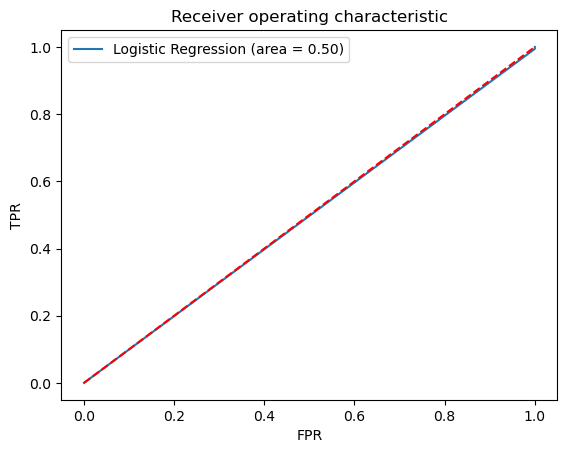

In [539]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#from imblearn.over_sampling import SMOTE

X = user_df.loc[:,user_df.columns[1:-2]]
y = user_df.loc[:,"similarity_label"]

#oversample = SMOTE(sampling_strategy = 0.5, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)
columns = X_train.columns
print(columns)
#oversample_data_X,oversample_data_y = oversample.fit_sample(X_train, y_train)
#oversample_data_X = pd.DataFrame(data=oversample_data_X,columns=columns )
#oversample_data_y = pd.DataFrame(data=oversample_data_y,columns=['similarity_label'])

#oversample_data_X
#oversample_data_y

#plt.title("Test set")
#plt.scatter(np.arange(0,len(X_test['avg_similarity'])),X_test['avg_similarity'], 
#            color = [('orange' if x > 0.4 else 'blue') for x in X_test['avg_similarity']])
#plt.axhline(linewidth=2, color='r', y=0.4)
#plt.show()

#plt.title("Training set")
#plt.scatter(np.arange(0,len(oversample_data_y['similarity_label'])),oversample_data_X['avg_similarity'], 
#            color = [('orange' if x > 0.4 else 'blue') for x in oversample_data_X['avg_similarity']])
#plt.axhline(linewidth=2, color='r', y=0.4)
#plt.show()

#oversample_data_X = oversample_data_X.loc[:, oversample_data_X.columns != "avg_similarity"]
#X_test = X_test.loc[:, X_test.columns != "avg_similarity"]

model = LogisticRegression()
model.fit(X_train, y_train.ravel())
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
parameters = model.coef_

print(accuracy)
print(parameters)
print(confusion_matrix(y_test, predicted_classes))
print(classification_report(y_test, predicted_classes))

y_test_mapped = [(1 if x == "Low similarity" else 0) for x in y_test]
predicted_classes_mapped = [(1 if x == "Low similarity" else 0) for x in predicted_classes]
logit_roc_auc = roc_auc_score(y_test_mapped, predicted_classes_mapped)
logit_roc_auc 
fpr, tpr, thresholds = roc_curve(y_test_mapped, predicted_classes_mapped)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.show()

Index(['avg_num_mentions', 'avg_num_links', 'follower_ratio',
       'avg_num_hashtags', 'retweet_unique_proportion', 'avg_similarity'],
      dtype='object')
0.9719626168224299
[[-7.93383019e-02 -2.04959455e-01  6.04728765e-04 -7.93676082e-02
   2.95908496e-01 -1.76585588e+01]]
[[ 277   69]
 [   0 2115]]
                 precision    recall  f1-score   support

High similarity       1.00      0.80      0.89       346
 Low similarity       0.97      1.00      0.98      2115

       accuracy                           0.97      2461
      macro avg       0.98      0.90      0.94      2461
   weighted avg       0.97      0.97      0.97      2461



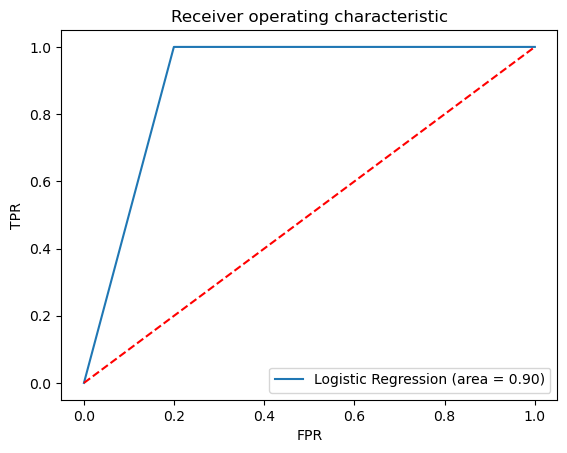

In [540]:
X = user_df.loc[:,user_df.columns[1:-1]]
y = user_df.loc[:,"similarity_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)
columns = X_train.columns
print(columns)

model = LogisticRegression()
model.fit(X_train, y_train.ravel())
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
parameters = model.coef_

print(accuracy)
print(parameters)
print(confusion_matrix(y_test, predicted_classes))
print(classification_report(y_test, predicted_classes))

y_test_mapped = [(1 if x == "Low similarity" else 0) for x in y_test]
predicted_classes_mapped = [(1 if x == "Low similarity" else 0) for x in predicted_classes]
logit_roc_auc = roc_auc_score(y_test_mapped, predicted_classes_mapped)
logit_roc_auc 
fpr, tpr, thresholds = roc_curve(y_test_mapped, predicted_classes_mapped)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.show()

In [475]:
print("logit(p) = %s\n + %s*%s + %s*%s\n + %s*%s + %s*%s\n + %s*%s - %s*%s"%(
    round(model.intercept_[0],3), 
    round(model.coef_[0][0],3), columns[0], 
    round(model.coef_[0][1],3), columns[1], 
    round(model.coef_[0][2],3), columns[2], 
    round(model.coef_[0][3],3), columns[3], 
    round(model.coef_[0][4],3), columns[4], 
    round(-1*model.coef_[0][5],3), columns[5]))

logit(p) = 8.02
 + -0.079*avg_num_mentions + -0.205*avg_num_links
 + 0.001*follower_ratio + -0.079*avg_num_hashtags
 + 0.296*retweet_unique_proportion - 17.659*avg_similarity


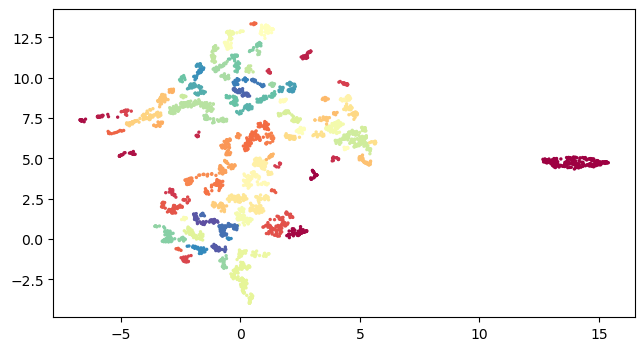

In [545]:
import hdbscan

labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=10
).fit_predict(embedding)

fig = plt.figure(figsize = (7.5,4))
clustered = (labels_hdbscan >= 0)
plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdbscan[clustered], s=2, cmap='Spectral')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]

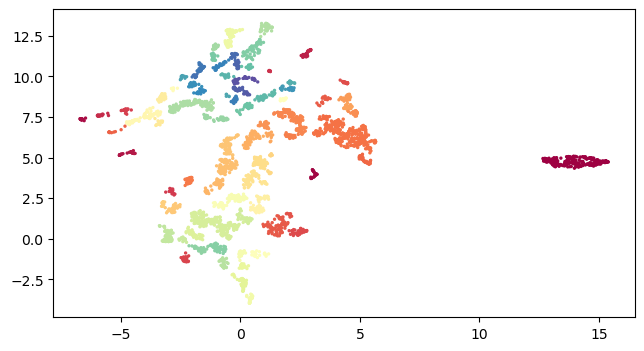

In [552]:
labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=13
).fit_predict(embedding)


fig = plt.figure(figsize = (7.5,4))
clustered = (labels_hdbscan >= 0)
plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdbscan[clustered], s=2, cmap='Spectral')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]

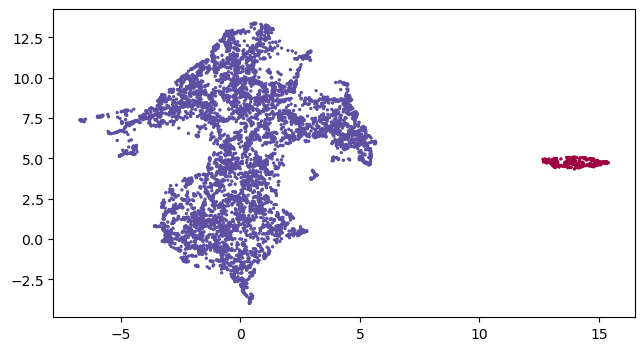

In [553]:
labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=15
).fit_predict(embedding)

fig = plt.figure(figsize = (7.5,4))
clustered = (labels_hdbscan >= 0)
plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdbscan[clustered], s=2, cmap='Spectral')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]

Index(['avg_num_mentions', 'avg_num_links', 'follower_ratio',
       'avg_num_hashtags', 'retweet_unique_proportion', 'avg_similarity'],
      dtype='object')
0.9991873222267371
[[ 2.53813615e+00 -2.99954776e+00  1.19667991e-04 -3.36940223e-01
  -7.55158012e+00 -8.22400452e+00]]
[[ 103    2]
 [   0 2356]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       105
         1.0       1.00      1.00      1.00      2356

    accuracy                           1.00      2461
   macro avg       1.00      0.99      0.99      2461
weighted avg       1.00      1.00      1.00      2461



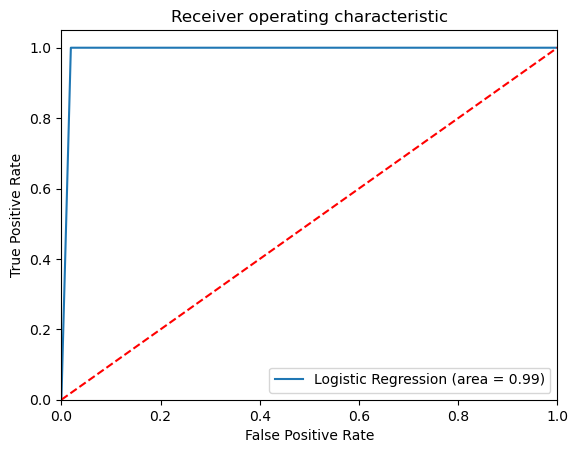

In [494]:
X = user_df.loc[:,user_df.columns[1:-3]]
y = user_df.loc[:,"cluster_hdbscan"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)
columns = X_train.columns
print(columns)

model = LogisticRegression()
model.fit(X_train, y_train.ravel())
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
parameters = model.coef_

print(accuracy)
print(parameters)

print(confusion_matrix(y_test, predicted_classes))
print(classification_report(y_test, predicted_classes))

y_test_mapped = [(1 if x == 1 else 0) for x in y_test]
predicted_classes_mapped = [(1 if x == 1 else 0) for x in predicted_classes]

logit_roc_auc = roc_auc_score(y_test_mapped, predicted_classes_mapped)
logit_roc_auc 
fpr, tpr, thresholds = roc_curve(y_test_mapped, predicted_classes_mapped)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [495]:
print("logit(p) = %s\n + %s*%s + %s*%s\n + %s*%s + %s*%s\n + %s*%s - %s*%s"%(
    round(model.intercept_[0],3), 
    round(model.coef_[0][0],3), columns[0], 
    round(model.coef_[0][1],3), columns[1], 
    round(model.coef_[0][2],3), columns[2], 
    round(model.coef_[0][3],3), columns[3], 
    round(model.coef_[0][4],3), columns[4], 
    round(-1*model.coef_[0][5],3), columns[5]))

logit(p) = 11.979
 + 2.538*avg_num_mentions + -3.0*avg_num_links
 + 0.0*follower_ratio + -0.337*avg_num_hashtags
 + -7.552*retweet_unique_proportion - 8.224*avg_similarity


<ipython-input-520-c5cc0e2c14af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df_ingroup["top_topic"] = [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in user_df_ingroup['user_id']]
<ipython-input-520-c5cc0e2c14af>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df_outgroup["top_topic"] = [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in user_df_outgroup['user_id']]


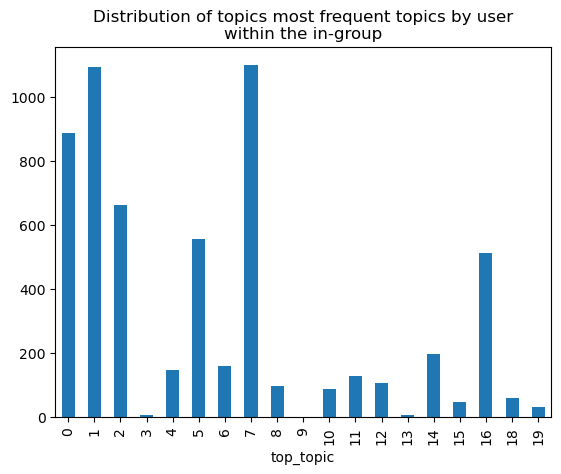

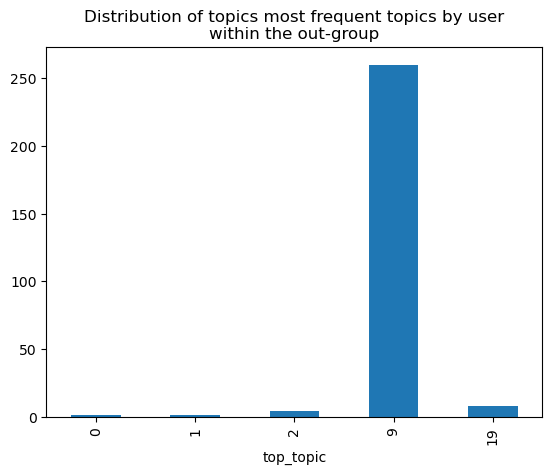

In [520]:
user_df_outgroup = user_df[user_df["cluster_hdbscan"] == 0]
user_df_ingroup = user_df[user_df["cluster_hdbscan"] == 1] 

    
user_df_ingroup["top_topic"] = [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in user_df_ingroup['user_id']]
user_df_outgroup["top_topic"] = [frequent_users_grouped.get_group(i).loc[:,"top_topic"].value_counts().idxmax() for i in user_df_outgroup['user_id']]
plt.title("Distribution of topics most frequent topics by user\nwithin the in-group")
user_df_ingroup.groupby(["top_topic"]).size().plot.bar()
plt.show()
plt.title("Distribution of topics most frequent topics by user\nwithin the out-group")
user_df_outgroup.groupby(["top_topic"]).size().plot.bar()
plt.show()



                     feature  importance
5             avg_similarity       0.638
3           avg_num_hashtags       0.255
4  retweet_unique_proportion       0.057
1              avg_num_links       0.042
2             follower_ratio       0.005
0           avg_num_mentions       0.004


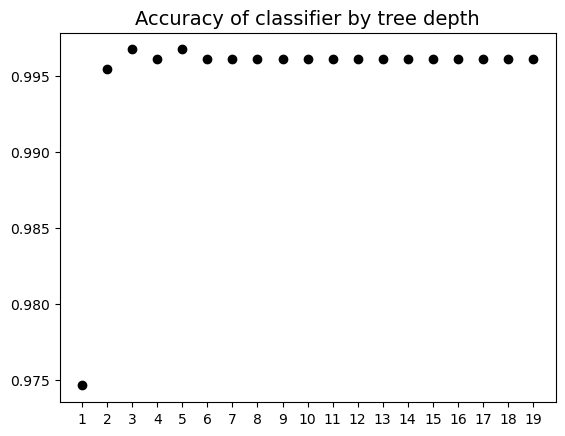

In [521]:
# Building a classifier to determine major features that determine decision making

from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(user_df.loc[:,user_df.columns[1:-3]], user_df['cluster_hdbscan'], random_state=0)

max_depth_range = list(range(1, 20))
for depth in max_depth_range:
    
    tree_classifier = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    tree_classifier.fit(X_train, Y_train)
    score = tree_classifier.score(X_test, Y_test)
    plt.scatter(depth,score, c = 'black')
    
plt.xticks([x for x in max_depth_range])    
plt.title('Accuracy of classifier by tree depth', fontsize=14)

tree_classifier = DecisionTreeClassifier(max_depth = 9, 
                             random_state = 0)
tree_classifier.fit(X_train, Y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(tree_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(importances.head(15))

                     feature  importance
0           avg_num_mentions       0.310
3           avg_num_hashtags       0.263
1              avg_num_links       0.195
4  retweet_unique_proportion       0.165
2             follower_ratio       0.067


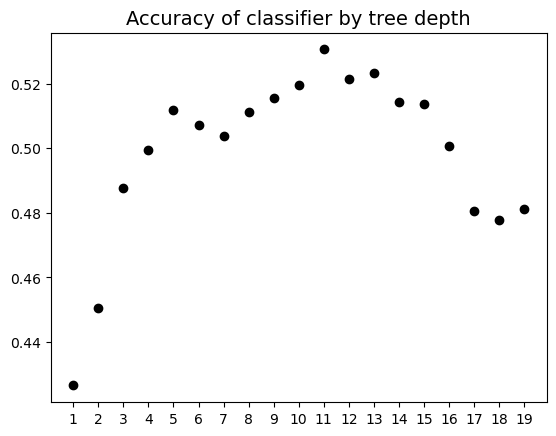

In [555]:
labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=13
).fit_predict(embedding)
for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]
    
X_train, X_test, Y_train, Y_test = train_test_split(user_df.loc[:,user_df.columns[1:-3]], user_df['cluster_hdbscan'], random_state=0)

max_depth_range = list(range(1, 20))
for depth in max_depth_range:
    
    tree_classifier = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    tree_classifier.fit(X_train, Y_train)
    score = tree_classifier.score(X_test, Y_test)
    plt.scatter(depth,score, c = 'black')
    
plt.xticks([x for x in max_depth_range])    
plt.title('Accuracy of classifier by tree depth', fontsize=14)

tree_classifier = DecisionTreeClassifier(max_depth = 11, 
                             random_state = 0)
tree_classifier.fit(X_train, Y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(tree_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

print(importances.head(15))